In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [10]:
def df_to_X_y(df,hoursToPredict, window_size):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + window_size)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+window_size]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + window_size ][0]
                y.append(label)
        return np.array(X), np.array(y)

In [11]:
def DataHandler(hoursToPredict,window_size):
    imputedMeasurementsDf = pd.read_csv('./../../../../Data/ProcessedData/Interpolation/interpolatedMeasurementsDf.csv')
    imputedMeasurementsDf = pd.DataFrame(imputedMeasurementsDf)
    imputedMeasurementsDf['time'] =  pd.to_datetime(imputedMeasurementsDf['time'], format='%Y-%m-%d %H:%M:%S')
    imputedMeasurementsDf.index = imputedMeasurementsDf['time']
    imputedMeasurementsDf = imputedMeasurementsDf.drop(['time'],axis = 1)
    
    X1, y1 = df_to_X_y(imputedMeasurementsDf,hoursToPredict,window_size)

    return X1, y1

In [12]:
 #DataHandler(1,1)

In [13]:
plt.style.use('seaborn')

In [14]:
def Trainer(time):
    window_size =  6
    while(window_size <= 12):
        model = Sequential()
        model.add(InputLayer((window_size, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,window_size)
        
        X_train, y_train = X[:92508], y[:92508] # training data
        X_val, y_val = X[92508:95508], y[92508:95508] #validation
        X_test, y_test = X[95508:], y[95508:] #test
        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
        
        cp1= ModelCheckpoint(str(time)+"H_ForecastModel_"+str(window_size)+"_SizeWindow/", save_best_only=True)
        model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.0001), 
                   metrics=[MeanAbsoluteError()])
    
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, callbacks=[cp1])
        window_size += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

    window_size = 6 #reset

In [19]:
def modelsEvaluator(time,startWindow,endWindow,jumpOneWindow):
    while(startWindow <= endWindow):
        X, y = DataHandler(time,startWindow)
        
        X_train, y_train = X[:92508], y[:92508] # training data
        X_val, y_val = X[92508:95508], y[92508:95508] #validation
        X_test, y_test = X[95508:], y[95508:] #test
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_ForecastModel_"+str(startWindow)+"_SizeWindow/")
        model = load_model(str(time)+"H_ForecastModel_"+str(startWindow)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        print('\n')
        if(jumpOneWindow):
            startWindow += 2
        else:
            startWindow += 1

 <h3> <font color='orange'> 1 hour forecasting model training </font> <h3/> 

In [16]:
%%time

Trainer(1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 19s 6ms/step - loss: 181.6841 - mean_absolute_error: 9.8773 - val_loss: 14.4947 - val_mean_absolute_error: 2.8352
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 18s 6ms/step - loss: 8.9005 - mean_absolute_error: 2.0616 - val_loss: 7.1230 - val_mean_absolute_error: 1.7819
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 16s 6ms/step - loss: 5.3427 - mean_absolute_error: 1.4999 - val_loss: 7.2526 - val_mean_absolute_error: 1.8411
Epoch 4/25
2891/2891 [==============================] - 20s 7ms/step - loss: 4.6764 - mean_absolute_error: 1.3269 - val_loss: 7.1410 - val_mean_absolute_error: 1.6685
Epoch 5/25
2891/2891 [==============================] - 16s 5ms/step - loss: 4.4418 - mean_absolute_error: 1.2433 - val_loss: 7.2604 - val_mean_absolute_error: 1.6449
Epoch 6/25
2891/2891 [==============================] - 16s 6ms/step - loss: 4.2871 - mean_absolute_error: 1.2039 - val_loss: 7.1812 - val_mean_absolute_error: 1.6446
Epoch 7/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.2102 - mean_absolute_error: 1.1897 - val_loss: 7.1597 - val_mean_absolute_error: 1.7271
Epoch 8/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.1771 - mean_absolute_error: 1.1818 - val_loss: 7.1709 - val_mean_absolute_error: 1.730

INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 19s 7ms/step - loss: 4.0774 - mean_absolute_error: 1.1647 - val_loss: 6.9887 - val_mean_absolute_error: 1.6598olute_error: - ETA: 2s - 
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 14/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.0760 - mean_absolute_error: 1.1628 - val_loss: 7.2876 - val_mean_absolute_error: 1.6506
Epoch 15/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.0626 - mean_absolute_error: 1.1578 - val_loss: 7.1432 - val_mean_absolute_error: 1.6317
Epoch 16/25
2891/2891 [==============================] - 14s 5ms/step - loss: 4.0433 - mean_absolute_error: 1.1585 - val_loss: 7.3325 - val_mean_absolute_error: 1.6516
Epoch 17/25
2891/2891 [==============================] - 14s 5ms/step - loss: 4.0245 - mean_absolute_error: 1.1583 - val_loss: 7.4424 - val_mean_absolute_error: 1.6668
Epoch 18/25
2891/2891 [==============================] - 14s 5ms/step - loss: 3.9909 - mean_absolute_error: 1.1547 - val_loss: 7.1856 - val_mean_absolute_error: 1.6413
Epoch 19/25
2891/2891 [==============================] - 14s 5ms/step - loss: 3.9769 - mean_absolute_error: 1.1494 - val_loss: 7.0090 - val_mean_absolute_error:

INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 21/25
2891/2891 [==============================] - 17s 6ms/step - loss: 3.9555 - mean_absolute_error: 1.1451 - val_loss: 7.1025 - val_mean_absolute_error: 1.6218
Epoch 22/25
2891/2891 [==============================] - 16s 5ms/step - loss: 3.9190 - mean_absolute_error: 1.1386 - val_loss: 6.9951 - val_mean_absolute_error: 1.6336
Epoch 23/25
2891/2891 [==============================] - 15s 5ms/step - loss: 3.9347 - mean_absolute_error: 1.1436 - val_loss: 7.0494 - val_mean_absolute_error: 1.6406
Epoch 24/25
2891/2891 [==============================] - 14s 5ms/step - loss: 3.9596 - mean_absolute_error: 1.1464 - val_loss: 6.9352 - val_mean_absolute_error: 1.6634
INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_6_SizeWindow\assets


Epoch 25/25
2891/2891 [==============================] - 15s 5ms/step - loss: 3.9311 - mean_absolute_error: 1.1413 - val_loss: 6.9924 - val_mean_absolute_error: 1.6447s - loss: 3.9327 - mean_absolute_error: 1.141

-----------------------------------------------------------------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 2

INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 18s 6ms/step - loss: 13.3611 - mean_absolute_error: 2.7475 - val_loss: 8.7753 - val_mean_absolute_error: 1.9016
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 16s 6ms/step - loss: 6.1667 - mean_absolute_error: 1.6895 - val_loss: 7.3914 - val_mean_absolute_error: 1.7289o
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 17s 6ms/step - loss: 4.6743 - mean_absolute_error: 1.3404 - val_loss: 7.3374 - val_mean_absolute_error: 1.6855
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 18s 6ms/step - loss: 4.3993 - mean_absolute_error: 1.2623 - val_loss: 7.0393 - val_mean_absolute_error: 1.6953
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 20s 7ms/step - loss: 4.2381 - mean_absolute_error: 1.2216 - val_loss: 7.3807 - val_mean_absolute_error: 1.6806
Epoch 7/25
2891/2891 [==============================] - 16s 5ms/step - loss: 4.1050 - mean_absolute_error: 1.1913 - val_loss: 7.7000 - val_mean_absolute_error: 1.7510
Epoch 8/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.0552 - mean_absolute_error: 1.1872 - val_loss: 7.0563 - val_mean_absolute_error: 1.6729 l
Epoch 9/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.0284 - mean_absolute_error: 1.1798 - val_loss: 7.0781 - val_mean_absolute_error: 1.6587
Epoch 10/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.0099 - mean_absolute_error: 1.1731 - val_loss: 7.2050 - val_mean_absolute_error: 1.6828
Epoch 11/25
2891/2891 [==============================] - 15s 5ms/step - loss: 4.0742 - mean_absolute_error: 1.1818 - val_loss: 7.7312 - val_mean_absolute_error: 1

INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 14/25
2891/2891 [==============================] - 16s 6ms/step - loss: 3.9074 - mean_absolute_error: 1.1531 - val_loss: 6.9925 - val_mean_absolute_error: 1.6907
INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 15/25
2891/2891 [==============================] - 19s 7ms/step - loss: 3.9325 - mean_absolute_error: 1.1575 - val_loss: 7.1882 - val_mean_absolute_error: 1.6843
Epoch 16/25
2891/2891 [==============================] - 16s 6ms/step - loss: 3.8985 - mean_absolute_error: 1.1494 - val_loss: 7.1213 - val_mean_absolute_error: 1.7583
Epoch 17/25
2891/2891 [==============================] - 15s 5ms/step - loss: 3.8978 - mean_absolute_error: 1.1501 - val_loss: 7.0522 - val_mean_absolute_error: 1.7616
Epoch 18/25
2891/2891 [==============================] - 15s 5ms/step - loss: 3.8955 - mean_absolute_error: 1.1471 - val_loss: 7.0192 - val_mean_absolute_error: 1.6570- ETA: 3s - loss: 3.8834 - mean_absolute_error: 1.1 - ETA: 3s - loss: 3.8838 -  - ETA: 2
Epoch 19/25
2891/2891 [==============================] - 15s 5ms/step - loss: 3.8697 - mean_absolute_error: 1.1424 - val_loss: 7.1708 - val_mean_absolute_error: 1.6738
Epoch 20/25
2891/2891 [==============================] - 15s 5ms/step - 

INFO:tensorflow:Assets written to: 1H_ForecastModel_7_SizeWindow\assets


Epoch 24/25
2891/2891 [==============================] - 18s 6ms/step - loss: 3.8742 - mean_absolute_error: 1.1411 - val_loss: 7.5523 - val_mean_absolute_error: 1.7840
Epoch 25/25
2891/2891 [==============================] - 19s 7ms/step - loss: 3.8267 - mean_absolute_error: 1.1303 - val_loss: 7.0393 - val_mean_absolute_error: 1.6778

-----------------------------------------------------------------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 18s 6ms/step - loss: 8.6787 - mean_absolute_error: 1.9788 - val_loss: 6.9488 - val_mean_absolute_error: 1.6996
INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 18s 6ms/step - loss: 5.1325 - mean_absolute_error: 1.3872 - val_loss: 6.9723 - val_mean_absolute_error: 1.6603
Epoch 4/25
2891/2891 [==============================] - 17s 6ms/step - loss: 4.5548 - mean_absolute_error: 1.2680 - val_loss: 7.3933 - val_mean_absolute_error: 1.8923
Epoch 5/25
2891/2891 [==============================] - 16s 6ms/step - loss: 4.4266 - mean_absolute_error: 1.2447 - val_loss: 7.5793 - val_mean_absolute_error: 1.7589
Epoch 6/25
2891/2891 [==============================] - 16s 6ms/step - loss: 4.3473 - mean_absolute_error: 1.2244 - val_loss: 7.2292 - val_mean_absolute_error: 1.708902 - mean_absolute_error: 1.22
Epoch 7/25
2891/2891 [==============================] - 16s 6ms/step - loss: 4.2512 - mean_absolute_error: 1.2091 - val_loss: 7.5600 - val_mean_absolute_error: 1.7378
Epoch 8/25
2891/2891 [==============================] - 16s 6ms/step - loss: 4.1438 - mean_absolute_error: 1.1968 - val_loss: 7.1000 - 

INFO:tensorflow:Assets written to: 1H_ForecastModel_8_SizeWindow\assets


Epoch 21/25
2891/2891 [==============================] - 21s 7ms/step - loss: 3.8767 - mean_absolute_error: 1.1508 - val_loss: 7.0174 - val_mean_absolute_error: 1.7334
Epoch 22/25
2891/2891 [==============================] - 20s 7ms/step - loss: 3.8791 - mean_absolute_error: 1.1544 - val_loss: 7.2004 - val_mean_absolute_error: 1.7581
Epoch 23/25
2891/2891 [==============================] - 23s 8ms/step - loss: 3.8838 - mean_absolute_error: 1.1529 - val_loss: 6.9500 - val_mean_absolute_error: 1.6781
Epoch 24/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.8723 - mean_absolute_error: 1.1476 - val_loss: 6.9140 - val_mean_absolute_error: 1.6873
Epoch 25/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.8686 - mean_absolute_error: 1.1495 - val_loss: 7.0964 - val_mean_absolute_error: 1.6850

-----------------------------------------------------------------------------------------------------------

Model: "sequential_3"
____________________________

INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 22s 8ms/step - loss: 9.8207 - mean_absolute_error: 2.1346 - val_loss: 8.2040 - val_mean_absolute_error: 1.8394
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 30s 10ms/step - loss: 5.3274 - mean_absolute_error: 1.4174 - val_loss: 7.7563 - val_mean_absolute_error: 1.7117
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 30s 10ms/step - loss: 4.6424 - mean_absolute_error: 1.2912 - val_loss: 7.5592 - val_mean_absolute_error: 1.6770
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 26s 9ms/step - loss: 4.3938 - mean_absolute_error: 1.2403 - val_loss: 7.8855 - val_mean_absolute_error: 1.7879
Epoch 6/25
2891/2891 [==============================] - 32s 11ms/step - loss: 4.2889 - mean_absolute_error: 1.2209 - val_loss: 7.8193 - val_mean_absolute_error: 1.7572
Epoch 7/25
2891/2891 [==============================] - 25s 9ms/step - loss: 4.2495 - mean_absolute_error: 1.2227 - val_loss: 7.3846 - val_mean_absolute_error: 1.7341
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 23s 8ms/step - loss: 4.1666 - mean_absolute_error: 1.2027 - val_loss: 7.1610 - val_mean_absolute_error: 1.6946
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 22s 8ms/step - loss: 4.0888 - mean_absolute_error: 1.1913 - val_loss: 7.9742 - val_mean_absolute_error: 1.8662
Epoch 10/25
2891/2891 [==============================] - 22s 8ms/step - loss: 4.0933 - mean_absolute_error: 1.1935 - val_loss: 7.8340 - val_mean_absolute_error: 1.8270
Epoch 11/25
2891/2891 [==============================] - 22s 8ms/step - loss: 4.0358 - mean_absolute_error: 1.1843 - val_loss: 6.8927 - val_mean_absolute_error: 1.6622
INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_9_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.9863 - mean_absolute_error: 1.1751 - val_loss: 6.9026 - val_mean_absolute_error: 1.6739
Epoch 13/25
2891/2891 [==============================] - 23s 8ms/step - loss: 3.9510 - mean_absolute_error: 1.1678 - val_loss: 7.1868 - val_mean_absolute_error: 1.7219
Epoch 14/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.9803 - mean_absolute_error: 1.1737 - val_loss: 7.0237 - val_mean_absolute_error: 1.6585
Epoch 15/25
2891/2891 [==============================] - 24s 8ms/step - loss: 3.9822 - mean_absolute_error: 1.1736 - val_loss: 6.9464 - val_mean_absolute_error: 1.6722
Epoch 16/25
2891/2891 [==============================] - 24s 8ms/step - loss: 3.8974 - mean_absolute_error: 1.1567 - val_loss: 6.9421 - val_mean_absolute_error: 1.6590
Epoch 17/25
2891/2891 [==============================] - 23s 8ms/step - loss: 3.9124 - mean_absolute_error: 1.1596 - val_loss: 6.9437 - val_mean_absolute_error:

INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 30s 10ms/step - loss: 11.6652 - mean_absolute_error: 2.4598 - val_loss: 8.1759 - val_mean_absolute_error: 1.9659
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 28s 10ms/step - loss: 5.7046 - mean_absolute_error: 1.5596 - val_loss: 7.2524 - val_mean_absolute_error: 1.7820
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 27s 9ms/step - loss: 4.8339 - mean_absolute_error: 1.3649 - val_loss: 7.3333 - val_mean_absolute_error: 1.7569
Epoch 5/25
2891/2891 [==============================] - 33s 11ms/step - loss: 4.5282 - mean_absolute_error: 1.2910 - val_loss: 7.3574 - val_mean_absolute_error: 1.7999
Epoch 6/25
2891/2891 [==============================] - 25s 9ms/step - loss: 4.2968 - mean_absolute_error: 1.2373 - val_loss: 7.3162 - val_mean_absolute_error: 1.7767
Epoch 7/25
2891/2891 [==============================] - 25s 9ms/step - loss: 4.2221 - mean_absolute_error: 1.2194 - val_loss: 7.2898 - val_mean_absolute_error: 1.7626
Epoch 8/25
2891/2891 [==============================] - 25s 9ms/step - loss: 4.1893 - mean_absolute_error: 1.2166 - val_loss: 7.2619 - val_mean_absolute_error: 1.7799
Epoch 9/25
2891/2891 [==============================] - 21s 7ms/step - loss: 4.1137 - mean_absolute_error: 1.2070 - val_loss: 7.1170 - val_mean_absolute_error: 1.76

INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 25s 9ms/step - loss: 4.0404 - mean_absolute_error: 1.1894 - val_loss: 7.2357 - val_mean_absolute_error: 1.7607
Epoch 11/25
2891/2891 [==============================] - 21s 7ms/step - loss: 3.9929 - mean_absolute_error: 1.1814 - val_loss: 7.2275 - val_mean_absolute_error: 1.8004
Epoch 12/25
2891/2891 [==============================] - 21s 7ms/step - loss: 3.9864 - mean_absolute_error: 1.1770 - val_loss: 7.0746 - val_mean_absolute_error: 1.7536
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 23s 8ms/step - loss: 4.0507 - mean_absolute_error: 1.1937 - val_loss: 7.0060 - val_mean_absolute_error: 1.7643
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 14/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.9996 - mean_absolute_error: 1.1802 - val_loss: 7.0052 - val_mean_absolute_error: 1.7097
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 15/25
2891/2891 [==============================] - 24s 8ms/step - loss: 3.9909 - mean_absolute_error: 1.1876 - val_loss: 7.1848 - val_mean_absolute_error: 1.7751
Epoch 16/25
2891/2891 [==============================] - 21s 7ms/step - loss: 3.9680 - mean_absolute_error: 1.1734 - val_loss: 7.2152 - val_mean_absolute_error: 1.7594
Epoch 17/25
2891/2891 [==============================] - 21s 7ms/step - loss: 3.8905 - mean_absolute_error: 1.1595 - val_loss: 7.3796 - val_mean_absolute_error: 1.8441
Epoch 18/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.9493 - mean_absolute_error: 1.1675 - val_loss: 7.2228 - val_mean_absolute_error: 1.7063
Epoch 19/25
2891/2891 [==============================] - 21s 7ms/step - loss: 3.9603 - mean_absolute_error: 1.1716 - val_loss: 6.9787 - val_mean_absolute_error: 1.7404
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 20/25
2891/2891 [==============================] - 24s 8ms/step - loss: 3.9390 - mean_absolute_error: 1.1629 - val_loss: 6.9990 - val_mean_absolute_error: 1.7568
Epoch 21/25
2891/2891 [==============================] - 22s 8ms/step - loss: 3.9238 - mean_absolute_error: 1.1614 - val_loss: 6.9606 - val_mean_absolute_error: 1.6885
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 22/25
2891/2891 [==============================] - 28s 10ms/step - loss: 3.9010 - mean_absolute_error: 1.1513 - val_loss: 6.9059 - val_mean_absolute_error: 1.7236
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 23/25
2891/2891 [==============================] - 48s 17ms/step - loss: 3.8695 - mean_absolute_error: 1.1474 - val_loss: 7.0281 - val_mean_absolute_error: 1.7116
Epoch 24/25
2891/2891 [==============================] - 30s 10ms/step - loss: 3.8343 - mean_absolute_error: 1.1425 - val_loss: 6.8897 - val_mean_absolute_error: 1.7029
INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_10_SizeWindow\assets


Epoch 25/25
2891/2891 [==============================] - 28s 10ms/step - loss: 3.8398 - mean_absolute_error: 1.1422 - val_loss: 6.9040 - val_mean_absolute_error: 1.7406

-----------------------------------------------------------------------------------------------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 35s 11ms/step - loss: 165.1438 - mean_absolut

INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 31s 11ms/step - loss: 8.3724 - mean_absolute_error: 2.0365 - val_loss: 7.1349 - val_mean_absolute_error: 1.6564
INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 30s 10ms/step - loss: 4.7817 - mean_absolute_error: 1.3588 - val_loss: 7.2784 - val_mean_absolute_error: 1.6903
Epoch 4/25
2891/2891 [==============================] - 31s 11ms/step - loss: 4.4197 - mean_absolute_error: 1.2633 - val_loss: 7.3801 - val_mean_absolute_error: 1.6987
Epoch 5/25
2891/2891 [==============================] - 30s 10ms/step - loss: 4.2523 - mean_absolute_error: 1.2227 - val_loss: 7.8136 - val_mean_absolute_error: 1.7955
Epoch 6/25
2891/2891 [==============================] - 36s 12ms/step - loss: 4.2231 - mean_absolute_error: 1.2151 - val_loss: 7.4376 - val_mean_absolute_error: 1.6847
Epoch 7/25
2891/2891 [==============================] - 30s 10ms/step - loss: 4.1212 - mean_absolute_error: 1.2005 - val_loss: 7.4830 - val_mean_absolute_error: 1.7052
Epoch 8/25
2891/2891 [==============================] - 30s 10ms/step - loss: 4.1140 - mean_absolute_error: 1.1994 - val_loss: 7.6175 - val_mean_absolute_error:

INFO:tensorflow:Assets written to: 1H_ForecastModel_11_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.9618 - mean_absolute_error: 1.1714 - val_loss: 7.2295 - val_mean_absolute_error: 1.6902
Epoch 14/25
2891/2891 [==============================] - 25s 9ms/step - loss: 4.0070 - mean_absolute_error: 1.1783 - val_loss: 7.2602 - val_mean_absolute_error: 1.6854
Epoch 15/25
2891/2891 [==============================] - 25s 9ms/step - loss: 3.9487 - mean_absolute_error: 1.1673 - val_loss: 7.3028 - val_mean_absolute_error: 1.6930
Epoch 16/25
2891/2891 [==============================] - 25s 8ms/step - loss: 3.9203 - mean_absolute_error: 1.1638 - val_loss: 7.1502 - val_mean_absolute_error: 1.6693
Epoch 17/25
2891/2891 [==============================] - 25s 9ms/step - loss: 3.9183 - mean_absolute_error: 1.1596 - val_loss: 7.4598 - val_mean_absolute_error: 1.7182
Epoch 18/25
2891/2891 [==============================] - 25s 9ms/step - loss: 3.9151 - mean_absolute_error: 1.1596 - val_loss: 7.1612 - val_mean_absolute_error:

INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 27s 9ms/step - loss: 19.0052 - mean_absolute_error: 3.3700 - val_loss: 9.0028 - val_mean_absolute_error: 1.9425
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 27s 9ms/step - loss: 7.4454 - mean_absolute_error: 1.8771 - val_loss: 7.3800 - val_mean_absolute_error: 1.7019
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 27s 9ms/step - loss: 4.8575 - mean_absolute_error: 1.3645 - val_loss: 7.5693 - val_mean_absolute_error: 1.6730
Epoch 5/25
2891/2891 [==============================] - 27s 9ms/step - loss: 4.3610 - mean_absolute_error: 1.2523 - val_loss: 7.3003 - val_mean_absolute_error: 1.7385
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 27s 9ms/step - loss: 4.2672 - mean_absolute_error: 1.2178 - val_loss: 7.6180 - val_mean_absolute_error: 1.6927
Epoch 7/25
2891/2891 [==============================] - 26s 9ms/step - loss: 4.1682 - mean_absolute_error: 1.2037 - val_loss: 7.2184 - val_mean_absolute_error: 1.6772
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 26s 9ms/step - loss: 4.1473 - mean_absolute_error: 1.1992 - val_loss: 7.6358 - val_mean_absolute_error: 1.7460
Epoch 9/25
2891/2891 [==============================] - 27s 9ms/step - loss: 4.1165 - mean_absolute_error: 1.1946 - val_loss: 7.3949 - val_mean_absolute_error: 1.6852
Epoch 10/25
2891/2891 [==============================] - 26s 9ms/step - loss: 4.0515 - mean_absolute_error: 1.1865 - val_loss: 7.2812 - val_mean_absolute_error: 1.6749
Epoch 11/25
2891/2891 [==============================] - 28s 10ms/step - loss: 3.9955 - mean_absolute_error: 1.1789 - val_loss: 7.0987 - val_mean_absolute_error: 1.6674
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.9839 - mean_absolute_error: 1.1782 - val_loss: 7.1729 - val_mean_absolute_error: 1.6760
Epoch 13/25
2891/2891 [==============================] - 27s 9ms/step - loss: 3.9517 - mean_absolute_error: 1.1723 - val_loss: 7.1035 - val_mean_absolute_error: 1.6748
Epoch 14/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.9453 - mean_absolute_error: 1.1678 - val_loss: 7.3950 - val_mean_absolute_error: 1.7233
Epoch 15/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.9319 - mean_absolute_error: 1.1668 - val_loss: 6.9766 - val_mean_absolute_error: 1.6909
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 16/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.8886 - mean_absolute_error: 1.1609 - val_loss: 7.1371 - val_mean_absolute_error: 1.6539 mean_absolute_e
Epoch 17/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.9046 - mean_absolute_error: 1.1617 - val_loss: 7.0255 - val_mean_absolute_error: 1.7240
Epoch 18/25
2891/2891 [==============================] - 27s 9ms/step - loss: 3.9050 - mean_absolute_error: 1.1633 - val_loss: 6.9659 - val_mean_absolute_error: 1.7009
INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 1H_ForecastModel_12_SizeWindow\assets


Epoch 19/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.9127 - mean_absolute_error: 1.1636 - val_loss: 7.2896 - val_mean_absolute_error: 1.6863
Epoch 20/25
2891/2891 [==============================] - 27s 9ms/step - loss: 3.9031 - mean_absolute_error: 1.1610 - val_loss: 7.3099 - val_mean_absolute_error: 1.6857
Epoch 21/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.8709 - mean_absolute_error: 1.1533 - val_loss: 7.0488 - val_mean_absolute_error: 1.6592
Epoch 22/25
2891/2891 [==============================] - 28s 10ms/step - loss: 3.8525 - mean_absolute_error: 1.1491 - val_loss: 7.0963 - val_mean_absolute_error: 1.6476
Epoch 23/25
2891/2891 [==============================] - 26s 9ms/step - loss: 3.8759 - mean_absolute_error: 1.1531 - val_loss: 7.0877 - val_mean_absolute_error: 1.6540
Epoch 24/25
2891/2891 [==============================] - 25s 9ms/step - loss: 3.8644 - mean_absolute_error: 1.1492 - val_loss: 7.0057 - val_mean_absolute_error

In [20]:
%%time

modelsEvaluator(1,6,12,False)

(92508, 6, 5) (92508,) (3000, 6, 5) (3000,) (19033, 6, 5) (19033,)
Loading: 1H_ForecastModel_6_SizeWindow/
595/595 [==============================] - 2s 3ms/step - loss: 6.5002 - mean_absolute_error: 1.7206


(92508, 7, 5) (92508,) (3000, 7, 5) (3000,) (19032, 7, 5) (19032,)
Loading: 1H_ForecastModel_7_SizeWindow/
595/595 [==============================] - 2s 2ms/step - loss: 6.2859 - mean_absolute_error: 1.6009


(92508, 8, 5) (92508,) (3000, 8, 5) (3000,) (19031, 8, 5) (19031,)
Loading: 1H_ForecastModel_8_SizeWindow/
595/595 [==============================] - 2s 3ms/step - loss: 6.3621 - mean_absolute_error: 1.7029


(92508, 9, 5) (92508,) (3000, 9, 5) (3000,) (19030, 9, 5) (19030,)
Loading: 1H_ForecastModel_9_SizeWindow/
595/595 [==============================] - 3s 4ms/step - loss: 6.3006 - mean_absolute_error: 1.6048A: 0s - loss: 6.3571 - mean_absolute_error: 1.616


(92508, 10, 5) (92508,) (3000, 10, 5) (3000,) (19029, 10, 5) (19029,)
Loading: 1H_ForecastModel_10_SizeWindow/
595/

In [35]:
model = load_model('1H_ForecastModel_6_SizeWindow/')

In [36]:
X, y = DataHandler(1,6)
X_train, y_train = X[:92508], y[:92508] # training data
X_val, y_val = X[92508:95508], y[92508:95508] #validation
X_test, y_test = X[95508:], y[95508:] #test
model.evaluate(X_test,y_test)


595/595 [==============================] - 2s 2ms/step - loss: 6.5002 - mean_absolute_error: 1.7206


[6.5001959800720215, 1.7205581665039062]

In [37]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
plt.style.use('seaborn')

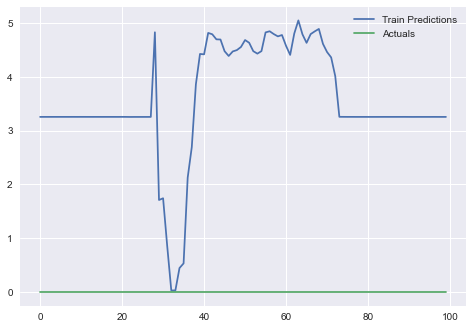

In [38]:
plt.plot(train_results['Train Predictions'][:100],)
plt.plot(train_results['Actuals'][:100])
plt.legend(['Train Predictions','Actuals'])

 <h3> <font color='orange'> 2 hour forecasting model training </font> <h3/> 

In [4]:
%%time

Trainer(2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 25s 8ms/step - loss: 1614759.1250 - mean_absolute_error: 666.7573 - val_loss: 289879.4375 - val_mean_absolute_error: 464.2599
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1537036.5000 - mean_absolute_error: 621.5223 - val_loss: 228113.6562 - val_mean_absolute_error: 396.4884
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1441971.3750 - mean_absolute_error: 571.2273 - val_loss: 163543.9531 - val_mean_absolute_error: 318.8539
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 19s 7ms/step - loss: 1336230.1250 - mean_absolute_error: 521.8998 - val_loss: 105343.7969 - val_mean_absolute_error: 239.7804
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1224256.7500 - mean_absolute_error: 478.1803 - val_loss: 60842.8203 - val_mean_absolute_error: 168.0081
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1109785.1250 - mean_absolute_error: 441.9043 - val_loss: 33976.4844 - val_mean_absolute_error: 116.5372
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 16s 6ms/step - loss: 992729.6250 - mean_absolute_error: 412.3720 - val_loss: 22632.9844 - val_mean_absolute_error: 89.5348
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 18s 6ms/step - loss: 875007.9375 - mean_absolute_error: 386.3388 - val_loss: 19472.1641 - val_mean_absolute_error: 83.5725
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 15s 5ms/step - loss: 757479.3125 - mean_absolute_error: 362.6536 - val_loss: 18511.5020 - val_mean_absolute_error: 84.0595loss: 7
INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 15s 5ms/step - loss: 641685.2500 - mean_absolute_error: 338.5860 - val_loss: 19715.4355 - val_mean_absolute_error: 90.8028
Epoch 11/25
2891/2891 [==============================] - 20s 7ms/step - loss: 530637.5625 - mean_absolute_error: 314.3402 - val_loss: 19083.1309 - val_mean_absolute_error: 86.8730
Epoch 12/25
2891/2891 [==============================] - 15s 5ms/step - loss: 426078.9688 - mean_absolute_error: 288.9360 - val_loss: 19452.9746 - val_mean_absolute_error: 86.7288
Epoch 13/25
2891/2891 [==============================] - 16s 5ms/step - loss: 330110.5625 - mean_absolute_error: 262.3799 - val_loss: 19060.7773 - val_mean_absolute_error: 86.1397
Epoch 14/25
2891/2891 [==============================] - 18s 6ms/step - loss: 245272.6875 - mean_absolute_error: 234.7582 - val_loss: 19446.6348 - val_mean_absolute_error: 86.4280
Epoch 15/25
2891/2891 [==============================] - 18s 6ms/step - loss: 174574.3906 - mean_abs

INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 25s 9ms/step - loss: 1473440.1250 - mean_absolute_error: 587.6243 - val_loss: 171373.6250 - val_mean_absolute_error: 329.0586
INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1328335.1250 - mean_absolute_error: 519.8150 - val_loss: 92847.9453 - val_mean_absolute_error: 221.6968
INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1173698.5000 - mean_absolute_error: 462.6079 - val_loss: 42127.5820 - val_mean_absolute_error: 135.5322
INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1016643.0625 - mean_absolute_error: 419.6761 - val_loss: 23344.1836 - val_mean_absolute_error: 92.8871
INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 23s 8ms/step - loss: 857279.2500 - mean_absolute_error: 384.7317 - val_loss: 19702.6953 - val_mean_absolute_error: 86.2097
INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 31s 11ms/step - loss: 700263.5625 - mean_absolute_error: 352.1752 - val_loss: 19023.6699 - val_mean_absolute_error: 83.9109
INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 26s 9ms/step - loss: 549899.9375 - mean_absolute_error: 319.4894 - val_loss: 19583.9512 - val_mean_absolute_error: 87.0495
Epoch 9/25
2891/2891 [==============================] - 24s 8ms/step - loss: 410718.1250 - mean_absolute_error: 285.3645 - val_loss: 19206.9980 - val_mean_absolute_error: 84.0099
Epoch 10/25
2891/2891 [==============================] - 26s 9ms/step - loss: 282249.3125 - mean_absolute_error: 246.8065 - val_loss: 19473.0996 - val_mean_absolute_error: 83.4873
Epoch 11/25
2891/2891 [==============================] - 25s 9ms/step - loss: 181542.0938 - mean_absolute_error: 208.0924 - val_loss: 20169.5664 - val_mean_absolute_error: 86.1457
Epoch 12/25
2891/2891 [==============================] - 23s 8ms/step - loss: 111647.0391 - mean_absolute_error: 169.4274 - val_loss: 20143.8379 - val_mean_absolute_error: 86.5349
Epoch 13/25
2891/2891 [==============================] - 23s 8ms/step - loss: 74999.5234 - mean_absolu

INFO:tensorflow:Assets written to: 2H_ForecastModel_8_SizeWindow\assets


Epoch 18/25
2891/2891 [==============================] - 24s 8ms/step - loss: 59471.6367 - mean_absolute_error: 103.0606 - val_loss: 19467.8770 - val_mean_absolute_error: 88.8283
Epoch 19/25
2891/2891 [==============================] - 24s 8ms/step - loss: 59595.3320 - mean_absolute_error: 106.6118 - val_loss: 20344.6133 - val_mean_absolute_error: 92.8418
Epoch 20/25
2891/2891 [==============================] - 23s 8ms/step - loss: 60092.6562 - mean_absolute_error: 108.7387 - val_loss: 21462.2871 - val_mean_absolute_error: 97.4726
Epoch 21/25
2891/2891 [==============================] - 22s 8ms/step - loss: 59323.1367 - mean_absolute_error: 102.9517 - val_loss: 20516.9355 - val_mean_absolute_error: 91.3017
Epoch 22/25
2891/2891 [==============================] - 21s 7ms/step - loss: 58918.8047 - mean_absolute_error: 104.8016 - val_loss: 21306.3047 - val_mean_absolute_error: 96.8082
Epoch 23/25
2891/2891 [==============================] - 22s 8ms/step - loss: 58420.5000 - mean_absolute_

INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1546775.0000 - mean_absolute_error: 626.9493 - val_loss: 235973.5000 - val_mean_absolute_error: 405.2179
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1453497.0000 - mean_absolute_error: 577.6198 - val_loss: 171592.2031 - val_mean_absolute_error: 329.0777.7500 - mean_absolute_error: 
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 25s 9ms/step - loss: 1346675.3750 - mean_absolute_error: 527.0914 - val_loss: 110832.3438 - val_mean_absolute_error: 249.0054
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1233225.7500 - mean_absolute_error: 481.8295 - val_loss: 64221.3008 - val_mean_absolute_error: 176.4253
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1117175.7500 - mean_absolute_error: 444.1849 - val_loss: 35833.0586 - val_mean_absolute_error: 122.8105
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1000245.9375 - mean_absolute_error: 414.8907 - val_loss: 24107.8047 - val_mean_absolute_error: 95.8747
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 23s 8ms/step - loss: 882614.1250 - mean_absolute_error: 389.0336 - val_loss: 20425.2129 - val_mean_absolute_error: 88.8693
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 24s 8ms/step - loss: 766029.7500 - mean_absolute_error: 365.0667 - val_loss: 19106.1699 - val_mean_absolute_error: 86.0402bsolute_e
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 24s 8ms/step - loss: 650281.1875 - mean_absolute_error: 340.7320 - val_loss: 19346.2617 - val_mean_absolute_error: 88.8463
Epoch 11/25
2891/2891 [==============================] - 24s 8ms/step - loss: 537087.8750 - mean_absolute_error: 315.8812 - val_loss: 18880.7578 - val_mean_absolute_error: 87.0767
INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_10_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 25s 8ms/step - loss: 428778.9688 - mean_absolute_error: 289.2966 - val_loss: 19870.4922 - val_mean_absolute_error: 90.0542
Epoch 13/25
2891/2891 [==============================] - 25s 9ms/step - loss: 331141.8750 - mean_absolute_error: 262.3117 - val_loss: 19600.0527 - val_mean_absolute_error: 89.0433
Epoch 14/25
2891/2891 [==============================] - 28s 10ms/step - loss: 244368.9375 - mean_absolute_error: 233.8981 - val_loss: 20984.4941 - val_mean_absolute_error: 95.5817
Epoch 15/25
2891/2891 [==============================] - 30s 10ms/step - loss: 172932.4688 - mean_absolute_error: 205.0671 - val_loss: 20131.7871 - val_mean_absolute_error: 91.9459
Epoch 16/25
2891/2891 [==============================] - 28s 10ms/step - loss: 118346.4844 - mean_absolute_error: 176.0293 - val_loss: 20864.7246 - val_mean_absolute_error: 92.9785
Epoch 17/25
2891/2891 [==============================] - 32s 11ms/step - loss: 82877.0547 - mean_

INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 28s 10ms/step - loss: 1468362.6250 - mean_absolute_error: 584.7789 - val_loss: 168132.1875 - val_mean_absolute_error: 324.8083
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 31s 11ms/step - loss: 1322726.7500 - mean_absolute_error: 517.8377 - val_loss: 90633.5078 - val_mean_absolute_error: 219.0517
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1167762.2500 - mean_absolute_error: 460.5444 - val_loss: 41360.4141 - val_mean_absolute_error: 134.9535
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 25s 9ms/step - loss: 1011604.9375 - mean_absolute_error: 418.9237 - val_loss: 24200.4590 - val_mean_absolute_error: 97.34332
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 26s 9ms/step - loss: 854188.0625 - mean_absolute_error: 384.9294 - val_loss: 20027.2188 - val_mean_absolute_error: 90.3825
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 25s 9ms/step - loss: 699097.3750 - mean_absolute_error: 352.2881 - val_loss: 19550.0566 - val_mean_absolute_error: 87.6843
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 25s 9ms/step - loss: 550907.1875 - mean_absolute_error: 320.1913 - val_loss: 19854.2793 - val_mean_absolute_error: 88.6660ror: 321. - ETA - ETA: 0s - loss: 551793.9375 - mean_absolute_error
Epoch 9/25
2891/2891 [==============================] - 25s 9ms/step - loss: 412644.5625 - mean_absolute_error: 286.2987 - val_loss: 20281.2734 - val_mean_absolute_error: 88.6413
Epoch 10/25
2891/2891 [==============================] - 25s 9ms/step - loss: 290238.1875 - mean_absolute_error: 250.2491 - val_loss: 19848.5723 - val_mean_absolute_error: 88.2688
Epoch 11/25
2891/2891 [==============================] - 25s 9ms/step - loss: 189859.5781 - mean_absolute_error: 212.6752 - val_loss: 20782.1484 - val_mean_absolute_error: 93.1030
Epoch 12/25
2891/2891 [==============================] - 25s 9ms/step - loss: 121378.0391 - mean_absolute_error: 176.9077 - val_loss: 19519.7031 - val_mean_absolute_error: 89.0030
INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 25s 9ms/step - loss: 78326.7266 - mean_absolute_error: 140.3261 - val_loss: 19921.7207 - val_mean_absolute_error: 88.2999
Epoch 14/25
2891/2891 [==============================] - 31s 11ms/step - loss: 64047.4258 - mean_absolute_error: 117.5319 - val_loss: 19284.9180 - val_mean_absolute_error: 86.8173
INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 2H_ForecastModel_12_SizeWindow\assets


Epoch 15/25
2891/2891 [==============================] - 31s 11ms/step - loss: 61464.0547 - mean_absolute_error: 110.6427 - val_loss: 19669.3848 - val_mean_absolute_error: 86.8890733.0859 - mean_absolute_error:
Epoch 16/25
2891/2891 [==============================] - 36s 12ms/step - loss: 60548.1406 - mean_absolute_error: 107.9930 - val_loss: 20045.1230 - val_mean_absolute_error: 91.8267
Epoch 17/25
2891/2891 [==============================] - 32s 11ms/step - loss: 60989.1289 - mean_absolute_error: 109.4680 - val_loss: 19647.4414 - val_mean_absolute_error: 89.7223s
Epoch 18/25
2891/2891 [==============================] - 28s 10ms/step - loss: 60343.9062 - mean_absolute_error: 105.6075 - val_loss: 22154.2754 - val_mean_absolute_error: 101.4899
Epoch 19/25
2891/2891 [==============================] - 31s 11ms/step - loss: 60223.4648 - mean_absolute_error: 106.4397 - val_loss: 21654.3887 - val_mean_absolute_error: 99.0216
Epoch 20/25
2891/2891 [==============================] - 31s 11ms/s

In [13]:
%%time

modelsEvaluator(2,6,12,False)

Loading: 2H_ForecastModel_6_SizeWindow/
629/629 [==============================] - 3s 3ms/step - loss: 199852.1875 - mean_absolute_error: 151.7400


Loading: 2H_ForecastModel_8_SizeWindow/
629/629 [==============================] - 4s 5ms/step - loss: 56506.0586 - mean_absolute_error: 107.2712


Loading: 2H_ForecastModel_10_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 146394.3438 - mean_absolute_error: 136.2628: 1s - loss: 241


Loading: 2H_ForecastModel_12_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 54943.1836 - mean_absolute_error: 96.5121TA: 1s - loss: 430


CPU times: total: 3min 9s
Wall time: 2min


 <h3> <font color='orange'> 3 hour forecasting model training </font> <h3/> 

In [5]:
%%time

Trainer(3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 31s 10ms/step - loss: 1605293.0000 - mean_absolute_error: 660.8758 - val_loss: 272114.0938 - val_mean_absolute_error: 445.0815
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 19s 6ms/step - loss: 1498745.2500 - mean_absolute_error: 603.8860 - val_loss: 193710.1875 - val_mean_absolute_error: 356.8222
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 19s 7ms/step - loss: 1375837.0000 - mean_absolute_error: 546.2384 - val_loss: 118838.7969 - val_mean_absolute_error: 262.030178972.6250 - mean_absolute_error:  - ETA: 1s - loss: 1378669.500
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1241396.1250 - mean_absolute_error: 494.6300 - val_loss: 64848.3633 - val_mean_absolute_error: 181.5609
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 19s 6ms/step - loss: 1107195.3750 - mean_absolute_error: 455.4671 - val_loss: 36548.1719 - val_mean_absolute_error: 127.5837
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 17s 6ms/step - loss: 968639.2500 - mean_absolute_error: 422.9948 - val_loss: 29203.9980 - val_mean_absolute_error: 110.7149
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 17s 6ms/step - loss: 830543.6250 - mean_absolute_error: 395.2537 - val_loss: 28547.3145 - val_mean_absolute_error: 109.8623
INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 18s 6ms/step - loss: 694014.5000 - mean_absolute_error: 368.2652 - val_loss: 28558.5625 - val_mean_absolute_error: 110.6142
Epoch 9/25
2891/2891 [==============================] - 18s 6ms/step - loss: 561879.2500 - mean_absolute_error: 340.6267 - val_loss: 29037.4160 - val_mean_absolute_error: 113.3344
Epoch 10/25
2891/2891 [==============================] - 18s 6ms/step - loss: 434850.0000 - mean_absolute_error: 309.4478 - val_loss: 29692.5918 - val_mean_absolute_error: 118.6557
Epoch 11/25
2891/2891 [==============================] - 18s 6ms/step - loss: 320825.9375 - mean_absolute_error: 277.0190 - val_loss: 28974.0137 - val_mean_absolute_error: 113.9271
Epoch 12/25
2891/2891 [==============================] - 18s 6ms/step - loss: 225456.0625 - mean_absolute_error: 243.0535 - val_loss: 29852.4844 - val_mean_absolute_error: 115.9957
Epoch 13/25
2891/2891 [==============================] - 18s 6ms/step - loss: 152669.3281 - mean_

INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1488358.7500 - mean_absolute_error: 597.0765 - val_loss: 183023.5781 - val_mean_absolute_error: 344.3236
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1352554.3750 - mean_absolute_error: 534.7612 - val_loss: 106716.3594 - val_mean_absolute_error: 245.9174solute_error:  - ETA: 2s - los
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 22s 8ms/step - loss: 1212380.8750 - mean_absolute_error: 484.5818 - val_loss: 56018.6836 - val_mean_absolute_error: 166.7331
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 25s 9ms/step - loss: 1069239.6250 - mean_absolute_error: 445.7228 - val_loss: 33668.3086 - val_mean_absolute_error: 121.4323- mean_absolute_error: 451.75 - ETA  - ETA: 1s - loss: 1073489.8750
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 23s 8ms/step - loss: 924584.3750 - mean_absolute_error: 413.8841 - val_loss: 29850.6113 - val_mean_absolute_error: 111.6618
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 20s 7ms/step - loss: 780659.5000 - mean_absolute_error: 385.2255 - val_loss: 29479.6719 - val_mean_absolute_error: 112.6213
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 21s 7ms/step - loss: 639365.1875 - mean_absolute_error: 357.6395 - val_loss: 30771.0527 - val_mean_absolute_error: 113.7829
Epoch 9/25
2891/2891 [==============================] - 21s 7ms/step - loss: 504934.8438 - mean_absolute_error: 326.8611 - val_loss: 28819.7383 - val_mean_absolute_error: 111.0268
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 21s 7ms/step - loss: 380967.4062 - mean_absolute_error: 294.6279 - val_loss: 28664.6504 - val_mean_absolute_error: 109.7642
INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
2891/2891 [==============================] - 20s 7ms/step - loss: 273189.1562 - mean_absolute_error: 261.0268 - val_loss: 30061.2266 - val_mean_absolute_error: 114.1960
Epoch 12/25
2891/2891 [==============================] - 20s 7ms/step - loss: 188449.8750 - mean_absolute_error: 226.9265 - val_loss: 29897.2793 - val_mean_absolute_error: 113.9055
Epoch 13/25
2891/2891 [==============================] - 20s 7ms/step - loss: 127195.6406 - mean_absolute_error: 191.7670 - val_loss: 30274.1621 - val_mean_absolute_error: 116.1444
Epoch 14/25
2891/2891 [==============================] - 21s 7ms/step - loss: 96750.7891 - mean_absolute_error: 164.4380 - val_loss: 31555.0820 - val_mean_absolute_error: 118.9780loss: 96187.5781 -
Epoch 15/25
2891/2891 [==============================] - 21s 7ms/step - loss: 83342.5312 - mean_absolute_error: 141.0044 - val_loss: 31325.7812 - val_mean_absolute_error: 118.2095
Epoch 16/25
2891/2891 [==============================] - 21s 7ms/step - loss: 8

INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 25s 9ms/step - loss: 1478811.1250 - mean_absolute_error: 592.3412 - val_loss: 179493.5625 - val_mean_absolute_error: 339.6522
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1351153.6250 - mean_absolute_error: 533.6480 - val_loss: 108727.0469 - val_mean_absolute_error: 249.0023
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 22s 8ms/step - loss: 1217502.2500 - mean_absolute_error: 486.1811 - val_loss: 59564.0977 - val_mean_absolute_error: 174.5712
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1083434.1250 - mean_absolute_error: 450.2035 - val_loss: 37135.1406 - val_mean_absolute_error: 130.5757
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 28s 10ms/step - loss: 941848.6250 - mean_absolute_error: 419.5259 - val_loss: 31994.2676 - val_mean_absolute_error: 117.9526
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 27s 9ms/step - loss: 803166.5000 - mean_absolute_error: 392.8548 - val_loss: 31354.2969 - val_mean_absolute_error: 116.4424
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 27s 9ms/step - loss: 666960.6875 - mean_absolute_error: 365.1265 - val_loss: 30476.0059 - val_mean_absolute_error: 114.3744
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 26s 9ms/step - loss: 535272.5000 - mean_absolute_error: 335.7585 - val_loss: 30568.0820 - val_mean_absolute_error: 113.5952
Epoch 10/25
2891/2891 [==============================] - 24s 8ms/step - loss: 412390.4375 - mean_absolute_error: 305.0252 - val_loss: 30450.5195 - val_mean_absolute_error: 115.2329
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 11/25
2891/2891 [==============================] - 25s 9ms/step - loss: 302808.9062 - mean_absolute_error: 272.7644 - val_loss: 33231.3203 - val_mean_absolute_error: 120.0344
Epoch 12/25
2891/2891 [==============================] - 31s 11ms/step - loss: 211535.8594 - mean_absolute_error: 238.3197 - val_loss: 29323.6367 - val_mean_absolute_error: 111.3820
INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_10_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 25s 9ms/step - loss: 144353.6406 - mean_absolute_error: 204.0182 - val_loss: 30644.6855 - val_mean_absolute_error: 114.6436
Epoch 14/25
2891/2891 [==============================] - 29s 10ms/step - loss: 103108.8359 - mean_absolute_error: 172.8026 - val_loss: 31682.5273 - val_mean_absolute_error: 119.4940
Epoch 15/25
2891/2891 [==============================] - 29s 10ms/step - loss: 96264.6016 - mean_absolute_error: 165.5857 - val_loss: 31716.2930 - val_mean_absolute_error: 117.9606
Epoch 16/25
2891/2891 [==============================] - 24s 8ms/step - loss: 87410.5312 - mean_absolute_error: 151.6709 - val_loss: 29393.9902 - val_mean_absolute_error: 111.9451
Epoch 17/25
2891/2891 [==============================] - 31s 11ms/step - loss: 80933.5391 - mean_absolute_error: 138.7798 - val_loss: 30120.9727 - val_mean_absolute_error: 116.2088
Epoch 18/25
2891/2891 [==============================] - 27s 9ms/step - loss: 78272.7109 - mean

INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 29s 10ms/step - loss: 1593874.1250 - mean_absolute_error: 653.8860 - val_loss: 286571.8750 - val_mean_absolute_error: 460.5585
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 27s 9ms/step - loss: 1549860.5000 - mean_absolute_error: 628.7765 - val_loss: 252028.2500 - val_mean_absolute_error: 423.0048
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 36s 13ms/step - loss: 1497437.3750 - mean_absolute_error: 600.4499 - val_loss: 213658.6406 - val_mean_absolute_error: 379.9690
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 31s 11ms/step - loss: 1438374.1250 - mean_absolute_error: 570.9827 - val_loss: 174616.8594 - val_mean_absolute_error: 333.8728
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1375192.3750 - mean_absolute_error: 542.1978 - val_loss: 137613.4688 - val_mean_absolute_error: 288.2580
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 29s 10ms/step - loss: 1309195.7500 - mean_absolute_error: 515.8181 - val_loss: 104937.4062 - val_mean_absolute_error: 244.7520
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 32s 11ms/step - loss: 1241523.6250 - mean_absolute_error: 491.8784 - val_loss: 77522.9766 - val_mean_absolute_error: 204.3262
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 34s 12ms/step - loss: 1172921.8750 - mean_absolute_error: 470.8342 - val_loss: 56932.6914 - val_mean_absolute_error: 170.8956 loss: 1172722.7500 - mean_absolute_err
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 36s 12ms/step - loss: 1103595.7500 - mean_absolute_error: 452.6510 - val_loss: 43256.2773 - val_mean_absolute_error: 144.800405953.6250 - mean_a
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 11/25
2891/2891 [==============================] - 35s 12ms/step - loss: 1034220.0000 - mean_absolute_error: 436.5581 - val_loss: 35500.7227 - val_mean_absolute_error: 127.0199
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 33s 11ms/step - loss: 963870.0000 - mean_absolute_error: 421.5001 - val_loss: 32439.3672 - val_mean_absolute_error: 118.2858
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 26s 9ms/step - loss: 893500.2500 - mean_absolute_error: 407.7388 - val_loss: 31277.1035 - val_mean_absolute_error: 117.2151
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 14/25
2891/2891 [==============================] - 24s 8ms/step - loss: 823156.0625 - mean_absolute_error: 394.5612 - val_loss: 30601.3652 - val_mean_absolute_error: 115.7903
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 15/25
2891/2891 [==============================] - 26s 9ms/step - loss: 752884.7500 - mean_absolute_error: 380.7129 - val_loss: 29317.5059 - val_mean_absolute_error: 111.7708
INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 3H_ForecastModel_12_SizeWindow\assets


Epoch 16/25
2891/2891 [==============================] - 31s 11ms/step - loss: 682602.8750 - mean_absolute_error: 365.9582 - val_loss: 29781.6270 - val_mean_absolute_error: 115.7931
Epoch 17/25
2891/2891 [==============================] - 27s 9ms/step - loss: 613278.0625 - mean_absolute_error: 351.8551 - val_loss: 30406.0996 - val_mean_absolute_error: 117.6459
Epoch 18/25
2891/2891 [==============================] - 25s 9ms/step - loss: 545664.6250 - mean_absolute_error: 337.7771 - val_loss: 30324.8691 - val_mean_absolute_error: 116.8434
Epoch 19/25
2891/2891 [==============================] - 23s 8ms/step - loss: 480837.6250 - mean_absolute_error: 321.9756 - val_loss: 30267.9121 - val_mean_absolute_error: 116.8893
Epoch 20/25
2891/2891 [==============================] - 25s 9ms/step - loss: 418094.1875 - mean_absolute_error: 305.7039 - val_loss: 30410.2246 - val_mean_absolute_error: 117.1944
Epoch 21/25
2891/2891 [==============================] - 21s 7ms/step - loss: 358924.1250 - me

In [15]:
%%time

modelsEvaluator(3,6,12,False)

Loading: 3H_ForecastModel_6_SizeWindow/
629/629 [==============================] - 3s 3ms/step - loss: 218091.0625 - mean_absolute_error: 162.9360: 0s - loss: 226262.0781 - mean_absolute_error: 166.


Loading: 3H_ForecastModel_8_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 118284.5859 - mean_absolute_error: 154.6538


Loading: 3H_ForecastModel_10_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 84388.6562 - mean_absolute_error: 133.7740A: 0s - loss: 94127.2266 - mean_absolute_error: 1


Loading: 3H_ForecastModel_12_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 209401.4375 - mean_absolute_error: 170.9045: 1s - loss: 31577


CPU times: total: 3min 17s
Wall time: 2min 5s


 <h3> <font color='orange'> 4 hour forecasting model training </font> <h3/> 

In [7]:
%%time

Trainer(4)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 18s 5ms/step - loss: 1608928.8750 - mean_absolute_error: 663.3605 - val_loss: 277280.7812 - val_mean_absolute_error: 450.6596
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 16s 6ms/step - loss: 1505212.3750 - mean_absolute_error: 607.7448 - val_loss: 196914.9219 - val_mean_absolute_error: 360.8551 4s - loss: 1512327.8750 - mean_a - ETA: 3s - loss: 1511196.0000 - mean_absolute
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 15s 5ms/step - loss: 1379807.6250 - mean_absolute_error: 551.2326 - val_loss: 121097.5156 - val_mean_absolute_error: 266.874240551 - ETA: 7s - loss: 1403220.6250 - m - ETA: 2s - los
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1246079.6250 - mean_absolute_error: 503.5970 - val_loss: 68126.7031 - val_mean_absolute_error: 191.1877
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1111284.7500 - mean_absolute_error: 468.2807 - val_loss: 42922.1797 - val_mean_absolute_error: 145.6711
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 16s 5ms/step - loss: 974199.1875 - mean_absolute_error: 438.9298 - val_loss: 38771.9023 - val_mean_absolute_error: 132.8311
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 17s 6ms/step - loss: 834794.1250 - mean_absolute_error: 412.5186 - val_loss: 41007.0898 - val_mean_absolute_error: 139.5834
Epoch 8/25
2891/2891 [==============================] - 17s 6ms/step - loss: 696226.9375 - mean_absolute_error: 384.5713 - val_loss: 38091.3672 - val_mean_absolute_error: 133.6158
INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 14s 5ms/step - loss: 562665.0625 - mean_absolute_error: 356.0258 - val_loss: 39549.2148 - val_mean_absolute_error: 138.3651
Epoch 10/25
2891/2891 [==============================] - 14s 5ms/step - loss: 436915.0312 - mean_absolute_error: 324.6117 - val_loss: 40532.7148 - val_mean_absolute_error: 139.0678n_absolute_error
Epoch 11/25
2891/2891 [==============================] - 14s 5ms/step - loss: 324688.7188 - mean_absolute_error: 291.4143 - val_loss: 40957.2070 - val_mean_absolute_error: 137.6997
Epoch 12/25
2891/2891 [==============================] - 14s 5ms/step - loss: 232155.1250 - mean_absolute_error: 257.4959 - val_loss: 38413.1133 - val_mean_absolute_error: 132.1715
Epoch 13/25
2891/2891 [==============================] - 14s 5ms/step - loss: 162735.5312 - mean_absolute_error: 222.6802 - val_loss: 40474.8438 - val_mean_absolute_error: 137.8775
Epoch 14/25
2891/2891 [==============================] - 14s 5ms/step - loss: 11

INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 20s 7ms/step - loss: 1590800.8750 - mean_absolute_error: 652.3990 - val_loss: 284220.6562 - val_mean_absolute_error: 458.0579
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 19s 7ms/step - loss: 1547736.8750 - mean_absolute_error: 628.2153 - val_loss: 249571.5625 - val_mean_absolute_error: 420.3162
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1495042.5000 - mean_absolute_error: 601.1419 - val_loss: 211932.9844 - val_mean_absolute_error: 378.1787
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1437188.8750 - mean_absolute_error: 573.2979 - val_loss: 173712.5000 - val_mean_absolute_error: 333.2430
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 19s 7ms/step - loss: 1375274.0000 - mean_absolute_error: 546.7114 - val_loss: 137599.6406 - val_mean_absolute_error: 288.8885lut
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 22s 8ms/step - loss: 1311602.1250 - mean_absolute_error: 522.5349 - val_loss: 106403.4062 - val_mean_absolute_error: 248.5874
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 20s 7ms/step - loss: 1246320.8750 - mean_absolute_error: 501.2693 - val_loss: 80585.6641 - val_mean_absolute_error: 211.2363s - loss: 1
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1179405.5000 - mean_absolute_error: 482.5657 - val_loss: 61759.3320 - val_mean_absolute_error: 182.5436
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 19s 7ms/step - loss: 1112071.3750 - mean_absolute_error: 466.2245 - val_loss: 49845.5078 - val_mean_absolute_error: 160.6926
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 11/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1044876.1875 - mean_absolute_error: 451.7379 - val_loss: 44280.5430 - val_mean_absolute_error: 147.8188
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 19s 7ms/step - loss: 975654.1250 - mean_absolute_error: 437.6391 - val_loss: 40337.9531 - val_mean_absolute_error: 137.7418
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 18s 6ms/step - loss: 905529.9375 - mean_absolute_error: 423.3924 - val_loss: 39779.0195 - val_mean_absolute_error: 137.4875
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 14/25
2891/2891 [==============================] - 21s 7ms/step - loss: 835058.6875 - mean_absolute_error: 410.0333 - val_loss: 39327.2812 - val_mean_absolute_error: 135.9922
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 15/25
2891/2891 [==============================] - 18s 6ms/step - loss: 764566.0625 - mean_absolute_error: 396.0574 - val_loss: 38983.1367 - val_mean_absolute_error: 136.2733
INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_8_SizeWindow\assets


Epoch 16/25
2891/2891 [==============================] - 21s 7ms/step - loss: 694701.0625 - mean_absolute_error: 381.8941 - val_loss: 39200.4141 - val_mean_absolute_error: 136.2301
Epoch 17/25
2891/2891 [==============================] - 18s 6ms/step - loss: 625574.5000 - mean_absolute_error: 366.9217 - val_loss: 39823.4258 - val_mean_absolute_error: 138.1482
Epoch 18/25
2891/2891 [==============================] - 16s 6ms/step - loss: 557660.5000 - mean_absolute_error: 351.5983 - val_loss: 41883.6680 - val_mean_absolute_error: 142.5721
Epoch 19/25
2891/2891 [==============================] - 17s 6ms/step - loss: 491707.7500 - mean_absolute_error: 335.7883 - val_loss: 46142.7852 - val_mean_absolute_error: 153.1021
Epoch 20/25
2891/2891 [==============================] - 16s 6ms/step - loss: 428274.7812 - mean_absolute_error: 319.1594 - val_loss: 45505.1484 - val_mean_absolute_error: 150.6559
Epoch 21/25
2891/2891 [==============================] - 16s 6ms/step - loss: 368045.5000 - mea

INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1492318.0000 - mean_absolute_error: 600.2323 - val_loss: 184454.5938 - val_mean_absolute_error: 346.3038
INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1349900.1250 - mean_absolute_error: 537.1956 - val_loss: 105005.3203 - val_mean_absolute_error: 245.7737
INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 22s 8ms/step - loss: 1201958.0000 - mean_absolute_error: 489.7968 - val_loss: 57618.9805 - val_mean_absolute_error: 174.3487
INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1054253.6250 - mean_absolute_error: 455.8903 - val_loss: 42915.0195 - val_mean_absolute_error: 143.9461 - mean_absolute_
INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 23s 8ms/step - loss: 904439.3125 - mean_absolute_error: 425.8506 - val_loss: 40303.6602 - val_mean_absolute_error: 137.2816
INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 24s 8ms/step - loss: 751170.3125 - mean_absolute_error: 395.8308 - val_loss: 39381.1875 - val_mean_absolute_error: 136.3442
INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_10_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 24s 8ms/step - loss: 600999.5625 - mean_absolute_error: 364.6143 - val_loss: 41258.1484 - val_mean_absolute_error: 140.6648
Epoch 9/25
2891/2891 [==============================] - 20s 7ms/step - loss: 457100.5625 - mean_absolute_error: 329.9146 - val_loss: 41473.4844 - val_mean_absolute_error: 144.9545
Epoch 10/25
2891/2891 [==============================] - 20s 7ms/step - loss: 330756.5312 - mean_absolute_error: 293.5664 - val_loss: 42505.9727 - val_mean_absolute_error: 141.3815
Epoch 11/25
2891/2891 [==============================] - 20s 7ms/step - loss: 230407.6406 - mean_absolute_error: 258.1966 - val_loss: 41410.6328 - val_mean_absolute_error: 141.7623
Epoch 12/25
2891/2891 [==============================] - 20s 7ms/step - loss: 152504.0000 - mean_absolute_error: 218.5440 - val_loss: 43191.2695 - val_mean_absolute_error: 150.3764
Epoch 13/25
2891/2891 [==============================] - 20s 7ms/step - loss: 108754.9688 - mean_

INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1490926.1250 - mean_absolute_error: 599.6274 - val_loss: 184112.8750 - val_mean_absolute_error: 345.7076
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1352297.2500 - mean_absolute_error: 537.9680 - val_loss: 107163.0625 - val_mean_absolute_error: 249.5195
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1209647.2500 - mean_absolute_error: 490.9694 - val_loss: 60573.1523 - val_mean_absolute_error: 181.1817
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 28s 10ms/step - loss: 1067070.7500 - mean_absolute_error: 458.1111 - val_loss: 43895.8555 - val_mean_absolute_error: 147.2531
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 28s 10ms/step - loss: 923092.6875 - mean_absolute_error: 431.3961 - val_loss: 42630.3281 - val_mean_absolute_error: 144.5176
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 25s 9ms/step - loss: 778519.0625 - mean_absolute_error: 404.6283 - val_loss: 40963.4648 - val_mean_absolute_error: 140.0593
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 26s 9ms/step - loss: 634320.3125 - mean_absolute_error: 373.7484 - val_loss: 41590.5703 - val_mean_absolute_error: 143.8584
Epoch 9/25
2891/2891 [==============================] - 22s 8ms/step - loss: 496189.3750 - mean_absolute_error: 342.3632 - val_loss: 41311.8008 - val_mean_absolute_error: 143.3783
Epoch 10/25
2891/2891 [==============================] - 22s 8ms/step - loss: 370196.0000 - mean_absolute_error: 307.2722 - val_loss: 41264.3320 - val_mean_absolute_error: 138.9539
Epoch 11/25
2891/2891 [==============================] - 22s 8ms/step - loss: 263922.7188 - mean_absolute_error: 271.9051 - val_loss: 41020.9609 - val_mean_absolute_error: 140.5758
Epoch 12/25
2891/2891 [==============================] - 22s 8ms/step - loss: 180516.7188 - mean_absolute_error: 234.2889 - val_loss: 39665.8711 - val_mean_absolute_error: 138.8015
INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 4H_ForecastModel_12_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 24s 8ms/step - loss: 127533.2969 - mean_absolute_error: 200.0733 - val_loss: 39745.1094 - val_mean_absolute_error: 139.2266
Epoch 14/25
2891/2891 [==============================] - 25s 9ms/step - loss: 99838.0938 - mean_absolute_error: 169.1471 - val_loss: 40938.3477 - val_mean_absolute_error: 143.1065
Epoch 15/25
2891/2891 [==============================] - 22s 7ms/step - loss: 93446.9062 - mean_absolute_error: 155.6511 - val_loss: 41379.2734 - val_mean_absolute_error: 143.9896
Epoch 16/25
2891/2891 [==============================] - 22s 7ms/step - loss: 92337.3906 - mean_absolute_error: 153.3495 - val_loss: 42519.6250 - val_mean_absolute_error: 145.4386
Epoch 17/25
2891/2891 [==============================] - 22s 8ms/step - loss: 91390.8359 - mean_absolute_error: 150.2059 - val_loss: 42300.4766 - val_mean_absolute_error: 145.3610
Epoch 18/25
2891/2891 [==============================] - 22s 7ms/step - loss: 90176.7188 - mean_abs

In [16]:
%%time

modelsEvaluator(4,6,12,False)

Loading: 4H_ForecastModel_6_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 192294.1562 - mean_absolute_error: 177.3426: 0s - loss: 296069.7812 - mean_absolu - ETA: 0s - loss: 232243.3281 - mean_absolute


Loading: 4H_ForecastModel_8_SizeWindow/
629/629 [==============================] - 4s 5ms/step - loss: 220491.6406 - mean_absolute_error: 193.2210


Loading: 4H_ForecastModel_10_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 204886.7500 - mean_absolute_error: 184.3049: 1s - loss: 111970.34 - ETA: 0s - loss: 234736.2188 - mean_absolute


Loading: 4H_ForecastModel_12_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 92028.3125 - mean_absolute_error: 152.2222


CPU times: total: 3min 11s
Wall time: 1min 54s


 <h3> <font color='orange'> 5 hour forecasting model training </font> <h3/> 

In [8]:
%%time

Trainer(5)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 21s 6ms/step - loss: 1630577.7500 - mean_absolute_error: 676.8676 - val_loss: 312572.4375 - val_mean_absolute_error: 487.8247loss: 16 - ETA: 2s - loss: 1633118.1
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1580864.2500 - mean_absolute_error: 647.0312 - val_loss: 267606.3750 - val_mean_absolute_error: 440.12119s - loss -
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 15s 5ms/step - loss: 1511145.3750 - mean_absolute_error: 610.7239 - val_loss: 214119.4844 - val_mean_absolute_error: 380.8032
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 15s 5ms/step - loss: 1426531.6250 - mean_absolute_error: 571.9284 - val_loss: 158448.7812 - val_mean_absolute_error: 315.2724
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 16s 5ms/step - loss: 1336283.0000 - mean_absolute_error: 536.5781 - val_loss: 110477.0469 - val_mean_absolute_error: 254.4220
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1243925.6250 - mean_absolute_error: 508.6293 - val_loss: 75450.5938 - val_mean_absolute_error: 205.6586.0000 -
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 15s 5ms/step - loss: 1150950.2500 - mean_absolute_error: 486.7787 - val_loss: 54695.8516 - val_mean_absolute_error: 171.8125
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 16s 6ms/step - loss: 1056248.1250 - mean_absolute_error: 466.6649 - val_loss: 46943.5430 - val_mean_absolute_error: 155.2927
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 15s 5ms/step - loss: 960382.6250 - mean_absolute_error: 448.5021 - val_loss: 46270.1445 - val_mean_absolute_error: 154.1445
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 10/25
2891/2891 [==============================] - 16s 5ms/step - loss: 863074.2500 - mean_absolute_error: 429.8180 - val_loss: 46360.0117 - val_mean_absolute_error: 152.6158
Epoch 11/25
2891/2891 [==============================] - 15s 5ms/step - loss: 764543.8750 - mean_absolute_error: 410.1390 - val_loss: 44930.1719 - val_mean_absolute_error: 153.1290
INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_6_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 23s 8ms/step - loss: 665833.1250 - mean_absolute_error: 389.5726 - val_loss: 46206.8711 - val_mean_absolute_error: 157.1317
Epoch 13/25
2891/2891 [==============================] - 19s 7ms/step - loss: 570430.3125 - mean_absolute_error: 368.6060 - val_loss: 47762.2930 - val_mean_absolute_error: 159.9314TA: 0s - loss: 570645.5000 - mean_absolute_error: 36
Epoch 14/25
2891/2891 [==============================] - 19s 7ms/step - loss: 479684.5938 - mean_absolute_error: 346.9231 - val_loss: 45419.7422 - val_mean_absolute_error: 155.2039
Epoch 15/25
2891/2891 [==============================] - 18s 6ms/step - loss: 394028.9688 - mean_absolute_error: 322.7907 - val_loss: 47778.0195 - val_mean_absolute_error: 160.8825
Epoch 16/25
2891/2891 [==============================] - 19s 6ms/step - loss: 316767.5000 - mean_absolute_error: 298.7103 - val_loss: 49118.0742 - val_mean_absolute_error: 166.6207
Epoch 17/25
2891/2891 [====================

INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1456431.6250 - mean_absolute_error: 585.5988 - val_loss: 157336.5781 - val_mean_absolute_error: 314.0426
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1299256.6250 - mean_absolute_error: 524.6282 - val_loss: 83299.0312 - val_mean_absolute_error: 218.0801
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1141605.3750 - mean_absolute_error: 483.7726 - val_loss: 53166.6523 - val_mean_absolute_error: 169.6696
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 23s 8ms/step - loss: 984095.7500 - mean_absolute_error: 453.9997 - val_loss: 49861.5195 - val_mean_absolute_error: 158.1925
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 22s 8ms/step - loss: 821139.1875 - mean_absolute_error: 423.1324 - val_loss: 49006.2461 - val_mean_absolute_error: 160.7802
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 24s 8ms/step - loss: 657985.4375 - mean_absolute_error: 387.9736 - val_loss: 48769.9883 - val_mean_absolute_error: 160.2754
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 21s 7ms/step - loss: 503286.0625 - mean_absolute_error: 352.3996 - val_loss: 47805.4062 - val_mean_absolute_error: 157.4406
INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_8_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 21s 7ms/step - loss: 363321.1875 - mean_absolute_error: 312.2549 - val_loss: 49627.5039 - val_mean_absolute_error: 159.0263
Epoch 10/25
2891/2891 [==============================] - 21s 7ms/step - loss: 248648.3594 - mean_absolute_error: 271.9496 - val_loss: 49461.4570 - val_mean_absolute_error: 160.8061
Epoch 11/25
2891/2891 [==============================] - 20s 7ms/step - loss: 166273.1406 - mean_absolute_error: 231.5767 - val_loss: 53931.3711 - val_mean_absolute_error: 173.8261
Epoch 12/25
2891/2891 [==============================] - 19s 7ms/step - loss: 122088.9844 - mean_absolute_error: 197.2978 - val_loss: 51540.1211 - val_mean_absolute_error: 167.7273
Epoch 13/25
2891/2891 [==============================] - 19s 7ms/step - loss: 106916.0391 - mean_absolute_error: 176.9671 - val_loss: 55458.9336 - val_mean_absolute_error: 170.4409
Epoch 14/25
2891/2891 [==============================] - 18s 6ms/step - loss: 102919.8516 - mean

INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1497340.5000 - mean_absolute_error: 603.4741 - val_loss: 192411.7188 - val_mean_absolute_error: 355.7593
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 27s 9ms/step - loss: 1371594.3750 - mean_absolute_error: 547.4560 - val_loss: 118856.9297 - val_mean_absolute_error: 265.9550
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1242032.8750 - mean_absolute_error: 504.5564 - val_loss: 71667.9375 - val_mean_absolute_error: 200.5802
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 27s 9ms/step - loss: 1114208.2500 - mean_absolute_error: 475.1139 - val_loss: 54026.0273 - val_mean_absolute_error: 169.9652
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 28s 10ms/step - loss: 987523.5000 - mean_absolute_error: 452.7417 - val_loss: 51900.2070 - val_mean_absolute_error: 162.5999
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 25s 9ms/step - loss: 856095.5000 - mean_absolute_error: 427.2868 - val_loss: 50091.7773 - val_mean_absolute_error: 158.9529
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 30s 10ms/step - loss: 723186.6250 - mean_absolute_error: 400.2278 - val_loss: 48071.7969 - val_mean_absolute_error: 159.7835
INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_10_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 25s 9ms/step - loss: 593392.6875 - mean_absolute_error: 372.5284 - val_loss: 50146.8203 - val_mean_absolute_error: 163.5362
Epoch 10/25
2891/2891 [==============================] - 28s 10ms/step - loss: 470043.5938 - mean_absolute_error: 342.0146 - val_loss: 49062.7930 - val_mean_absolute_error: 162.4153
Epoch 11/25
2891/2891 [==============================] - 25s 9ms/step - loss: 359063.4688 - mean_absolute_error: 310.7516 - val_loss: 50879.5586 - val_mean_absolute_error: 165.7045
Epoch 12/25
2891/2891 [==============================] - 25s 9ms/step - loss: 263345.0938 - mean_absolute_error: 277.4117 - val_loss: 50421.2891 - val_mean_absolute_error: 166.6608
Epoch 13/25
2891/2891 [==============================] - 26s 9ms/step - loss: 187914.7812 - mean_absolute_error: 243.7461 - val_loss: 52999.2422 - val_mean_absolute_error: 168.4146
Epoch 14/25
2891/2891 [==============================] - 25s 9ms/step - loss: 136170.5000 - mea

INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 30s 10ms/step - loss: 1510638.1250 - mean_absolute_error: 609.8495 - val_loss: 201733.1562 - val_mean_absolute_error: 366.4682
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 31s 11ms/step - loss: 1387730.8750 - mean_absolute_error: 553.7449 - val_loss: 127317.8438 - val_mean_absolute_error: 277.0822.5000 - mean_
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 27s 9ms/step - loss: 1257865.8750 - mean_absolute_error: 508.5010 - val_loss: 75004.3984 - val_mean_absolute_error: 206.6994
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 26s 9ms/step - loss: 1127180.0000 - mean_absolute_error: 477.0539 - val_loss: 52937.0547 - val_mean_absolute_error: 168.0464
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 31s 11ms/step - loss: 997395.8125 - mean_absolute_error: 453.6981 - val_loss: 51110.8125 - val_mean_absolute_error: 162.1736
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 30s 10ms/step - loss: 865759.8125 - mean_absolute_error: 430.5774 - val_loss: 51386.9102 - val_mean_absolute_error: 164.8462
Epoch 8/25
2891/2891 [==============================] - 31s 11ms/step - loss: 731991.1875 - mean_absolute_error: 404.0415 - val_loss: 50814.9180 - val_mean_absolute_error: 162.3805
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 29s 10ms/step - loss: 602211.1250 - mean_absolute_error: 377.1241 - val_loss: 53047.3125 - val_mean_absolute_error: 165.0758
Epoch 10/25
2891/2891 [==============================] - 27s 9ms/step - loss: 478164.6875 - mean_absolute_error: 348.2304 - val_loss: 51937.1562 - val_mean_absolute_error: 165.5272
Epoch 11/25
2891/2891 [==============================] - 28s 10ms/step - loss: 364707.4688 - mean_absolute_error: 316.2980 - val_loss: 50508.3789 - val_mean_absolute_error: 160.9342
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 12/25
2891/2891 [==============================] - 25s 9ms/step - loss: 265464.3125 - mean_absolute_error: 280.7254 - val_loss: 50214.0469 - val_mean_absolute_error: 162.2430
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 13/25
2891/2891 [==============================] - 29s 10ms/step - loss: 192355.2812 - mean_absolute_error: 248.3685 - val_loss: 51759.5625 - val_mean_absolute_error: 164.5476
Epoch 14/25
2891/2891 [==============================] - 26s 9ms/step - loss: 150313.1719 - mean_absolute_error: 221.9853 - val_loss: 51013.7383 - val_mean_absolute_error: 161.1951
Epoch 15/25
2891/2891 [==============================] - 27s 9ms/step - loss: 122409.7656 - mean_absolute_error: 198.2290 - val_loss: 49374.0195 - val_mean_absolute_error: 162.8556
INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 5H_ForecastModel_12_SizeWindow\assets


Epoch 16/25
2891/2891 [==============================] - 27s 9ms/step - loss: 108033.9141 - mean_absolute_error: 181.3160 - val_loss: 52414.9805 - val_mean_absolute_error: 170.0181
Epoch 17/25
2891/2891 [==============================] - 26s 9ms/step - loss: 100642.2500 - mean_absolute_error: 167.7832 - val_loss: 50046.1445 - val_mean_absolute_error: 166.5162
Epoch 18/25
2891/2891 [==============================] - 26s 9ms/step - loss: 97615.5781 - mean_absolute_error: 162.4185 - val_loss: 51726.8789 - val_mean_absolute_error: 168.4975- ETA: 10s - l - ETA: 8s - lo - ETA: 5s - loss:
Epoch 19/25
2891/2891 [==============================] - 23s 8ms/step - loss: 95026.1328 - mean_absolute_error: 156.7456 - val_loss: 52195.9844 - val_mean_absolute_error: 170.8480
Epoch 20/25
2891/2891 [==============================] - 26s 9ms/step - loss: 94395.2734 - mean_absolute_error: 156.8535 - val_loss: 51755.0312 - val_mean_absolute_error: 167.3176
Epoch 21/25
2891/2891 [============================

In [17]:
modelsEvaluator(5,6,12,False)

Loading: 5H_ForecastModel_6_SizeWindow/
629/629 [==============================] - 2s 3ms/step - loss: 220938.4375 - mean_absolute_error: 205.0320: 0s - loss: 282341.1250 - mean_abso


Loading: 5H_ForecastModel_8_SizeWindow/
629/629 [==============================] - 3s 3ms/step - loss: 156796.4688 - mean_absolute_error: 184.7960: 1s - l


Loading: 5H_ForecastModel_10_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 207805.5000 - mean_absolute_error: 201.7105


Loading: 5H_ForecastModel_12_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 102894.2969 - mean_absolute_error: 164.4225: 0s - loss: 141208.48 - ETA: 0s - loss: 103548.4844 - mean_absolute_error: 165.04




 <h3> <font color='orange'> 6 hour forecasting model training </font> <h3/> 

In [9]:
%%time

Trainer(6)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2891/2891 [==============================] - 17s 5ms/step - loss: 1599602.0000 - mean_absolute_error: 657.7785 - val_loss: 268297.2500 - val_mean_absolute_error: 440.8245
INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 15s 5ms/step - loss: 1490951.5000 - mean_absolute_error: 601.8550 - val_loss: 185950.3125 - val_mean_absolute_error: 348.3419- loss: 1492725.6250 - mean_absol - ETA: 0s - loss: 1490497.8750 - mean_absolute_error:
INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 16s 5ms/step - loss: 1361918.3750 - mean_absolute_error: 548.0846 - val_loss: 113760.9922 - val_mean_absolute_error: 259.6648
INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1232861.0000 - mean_absolute_error: 510.6877 - val_loss: 69949.4688 - val_mean_absolute_error: 199.4974: 1s - loss: 1235377.8750 - mean_absolute_error: 511.35 - ETA: 1s - loss: 1234321.7500 - mea
INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 15s 5ms/step - loss: 1103200.8750 - mean_absolute_error: 483.7262 - val_loss: 56142.2617 - val_mean_absolute_error: 175.8398
INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 18s 6ms/step - loss: 972114.1250 - mean_absolute_error: 460.3910 - val_loss: 54434.5000 - val_mean_absolute_error: 171.1975
INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_6_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 16s 5ms/step - loss: 838283.7500 - mean_absolute_error: 435.1100 - val_loss: 57020.3164 - val_mean_absolute_error: 176.0606
Epoch 8/25
2891/2891 [==============================] - 16s 5ms/step - loss: 703701.6250 - mean_absolute_error: 408.6972 - val_loss: 56689.4180 - val_mean_absolute_error: 179.6602
Epoch 9/25
2891/2891 [==============================] - 14s 5ms/step - loss: 573769.3750 - mean_absolute_error: 381.0135 - val_loss: 56141.6172 - val_mean_absolute_error: 174.8714
Epoch 10/25
2891/2891 [==============================] - 14s 5ms/step - loss: 451733.1562 - mean_absolute_error: 349.9161 - val_loss: 59599.2969 - val_mean_absolute_error: 185.7271
Epoch 11/25
2891/2891 [==============================] - 14s 5ms/step - loss: 341204.3438 - mean_absolute_error: 316.4416 - val_loss: 66500.0938 - val_mean_absolute_error: 197.315556706.3438 - mean_abso - ETA: 2s - - ETA: 1s
Epoch 12/25
2891/2891 [==============================]

INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1473666.0000 - mean_absolute_error: 594.1441 - val_loss: 172956.7188 - val_mean_absolute_error: 333.0531
INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1333457.2500 - mean_absolute_error: 537.5821 - val_loss: 96989.8359 - val_mean_absolute_error: 237.8037
INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 18s 6ms/step - loss: 1180949.2500 - mean_absolute_error: 496.9255 - val_loss: 60475.9609 - val_mean_absolute_error: 183.3406
INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 17s 6ms/step - loss: 1030442.4375 - mean_absolute_error: 468.6632 - val_loss: 56567.3672 - val_mean_absolute_error: 172.4735
INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_8_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 18s 6ms/step - loss: 875312.0000 - mean_absolute_error: 439.5821 - val_loss: 57915.3750 - val_mean_absolute_error: 177.3598
Epoch 7/25
2891/2891 [==============================] - 16s 6ms/step - loss: 713778.4375 - mean_absolute_error: 406.7817 - val_loss: 59868.4258 - val_mean_absolute_error: 184.6330
Epoch 8/25
2891/2891 [==============================] - 16s 6ms/step - loss: 559181.8125 - mean_absolute_error: 373.4294 - val_loss: 63420.1875 - val_mean_absolute_error: 189.9091
Epoch 9/25
2891/2891 [==============================] - 16s 6ms/step - loss: 416623.3750 - mean_absolute_error: 336.9327 - val_loss: 64001.7656 - val_mean_absolute_error: 188.7368
Epoch 10/25
2891/2891 [==============================] - 16s 6ms/step - loss: 294464.7812 - mean_absolute_error: 298.6225 - val_loss: 60634.0703 - val_mean_absolute_error: 183.4980
Epoch 11/25
2891/2891 [==============================] - 16s 6ms/step - loss: 203215.4062 - mean_ab

INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 20s 7ms/step - loss: 1532160.1250 - mean_absolute_error: 621.0744 - val_loss: 222902.7344 - val_mean_absolute_error: 390.7458
INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 21s 7ms/step - loss: 1429279.0000 - mean_absolute_error: 572.4841 - val_loss: 154774.8125 - val_mean_absolute_error: 310.8674
INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1317568.0000 - mean_absolute_error: 529.4718 - val_loss: 99083.7109 - val_mean_absolute_error: 241.0914
INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1202966.2500 - mean_absolute_error: 497.3613 - val_loss: 65746.0703 - val_mean_absolute_error: 192.5148
INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1087303.1250 - mean_absolute_error: 474.2780 - val_loss: 56371.5938 - val_mean_absolute_error: 173.9013
INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 7/25
2891/2891 [==============================] - 21s 7ms/step - loss: 972939.8125 - mean_absolute_error: 455.4592 - val_loss: 57153.3125 - val_mean_absolute_error: 174.7906
Epoch 8/25
2891/2891 [==============================] - 19s 7ms/step - loss: 855504.5000 - mean_absolute_error: 434.3078 - val_loss: 56169.8867 - val_mean_absolute_error: 176.1239
INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_10_SizeWindow\assets


Epoch 9/25
2891/2891 [==============================] - 22s 8ms/step - loss: 740632.8750 - mean_absolute_error: 412.7109 - val_loss: 59507.8672 - val_mean_absolute_error: 184.2667
Epoch 10/25
2891/2891 [==============================] - 21s 7ms/step - loss: 628998.7500 - mean_absolute_error: 388.3580 - val_loss: 58552.8164 - val_mean_absolute_error: 178.8904
Epoch 11/25
2891/2891 [==============================] - 19s 7ms/step - loss: 508893.9062 - mean_absolute_error: 359.1505 - val_loss: 60433.5664 - val_mean_absolute_error: 181.3286
Epoch 12/25
2891/2891 [==============================] - 19s 6ms/step - loss: 404593.7812 - mean_absolute_error: 331.6337 - val_loss: 62575.9219 - val_mean_absolute_error: 183.9508
Epoch 13/25
2891/2891 [==============================] - 19s 7ms/step - loss: 332350.5000 - mean_absolute_error: 309.0410 - val_loss: 60030.4062 - val_mean_absolute_error: 181.6739
Epoch 14/25
2891/2891 [==============================] - 19s 6ms/step - loss: 244934.9219 - mean

INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


Epoch 2/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1452058.6250 - mean_absolute_error: 582.0473 - val_loss: 148615.1875 - val_mean_absolute_error: 303.4077
INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


Epoch 3/25
2891/2891 [==============================] - 24s 8ms/step - loss: 1282000.3750 - mean_absolute_error: 518.5921 - val_loss: 77035.0234 - val_mean_absolute_error: 211.1081
INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


Epoch 4/25
2891/2891 [==============================] - 23s 8ms/step - loss: 1116020.5000 - mean_absolute_error: 480.1214 - val_loss: 55343.0391 - val_mean_absolute_error: 173.4267
INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


Epoch 5/25
2891/2891 [==============================] - 23s 8ms/step - loss: 955825.0000 - mean_absolute_error: 453.2197 - val_loss: 55323.1523 - val_mean_absolute_error: 172.3665
INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


Epoch 6/25
2891/2891 [==============================] - 25s 9ms/step - loss: 791804.4375 - mean_absolute_error: 423.0933 - val_loss: 55559.9609 - val_mean_absolute_error: 175.5413
Epoch 7/25
2891/2891 [==============================] - 21s 7ms/step - loss: 626550.3125 - mean_absolute_error: 388.6504 - val_loss: 55085.1367 - val_mean_absolute_error: 172.2113
INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


INFO:tensorflow:Assets written to: 6H_ForecastModel_12_SizeWindow\assets


Epoch 8/25
2891/2891 [==============================] - 26s 9ms/step - loss: 470847.7188 - mean_absolute_error: 351.7990 - val_loss: 57308.9766 - val_mean_absolute_error: 180.9203
Epoch 9/25
2891/2891 [==============================] - 22s 7ms/step - loss: 333480.7812 - mean_absolute_error: 311.5650 - val_loss: 58738.8750 - val_mean_absolute_error: 183.8460
Epoch 10/25
2891/2891 [==============================] - 21s 7ms/step - loss: 224884.8438 - mean_absolute_error: 268.8766 - val_loss: 56945.8945 - val_mean_absolute_error: 179.4681
Epoch 11/25
2891/2891 [==============================] - 21s 7ms/step - loss: 162121.9062 - mean_absolute_error: 234.2558 - val_loss: 55419.6172 - val_mean_absolute_error: 175.7007
Epoch 12/25
2891/2891 [==============================] - 22s 7ms/step - loss: 119209.7891 - mean_absolute_error: 197.8756 - val_loss: 62435.3086 - val_mean_absolute_error: 189.3022
Epoch 13/25
2891/2891 [==============================] - 21s 7ms/step - loss: 105352.8359 - mean_

In [18]:
modelsEvaluator(6,6,12,False)

Loading: 6H_ForecastModel_6_SizeWindow/
629/629 [==============================] - 3s 3ms/step - loss: 272325.7812 - mean_absolute_error: 234.4911


Loading: 6H_ForecastModel_8_SizeWindow/
629/629 [==============================] - 3s 3ms/step - loss: 283049.6250 - mean_absolute_error: 232.6124


Loading: 6H_ForecastModel_10_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 247804.1875 - mean_absolute_error: 220.0823


Loading: 6H_ForecastModel_12_SizeWindow/
629/629 [==============================] - 3s 4ms/step - loss: 191252.2656 - mean_absolute_error: 207.9549


